# Applying T-SNE on Amzon FineFood reviews

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import re  
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
import os
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/final.sqlite" "final.sqlite"

# Getting the Amzon Data from the  database by usinfg SqliteDatabase

In [0]:
con=sqlite3.connect("/home/bhargav/AAIC/DataSets/amazon-fine-food-reviews/database.sqlite")
filtered_data=pd.read_sql_query("""select * from Reviews where Score!=3""",con)
filtered_data.shape

 Amzon Data Consist of the 525814 Rows and 10 Columns

## To check whether dataset is balanced or not

In [0]:
filtered_data['Score']=filtered_data['Score'].map(lambda x: 1 if(x>3) else 0)
filtered_data['Score'].value_counts()

In [0]:
filtered_data['Score'].shape[0]
for label,count in filtered_data['Score'].value_counts().iteritems():
    print("for class ",label," the count is ",count,"and percentage is", round(count/filtered_data['Score'].shape[0]*100,3) )

* Amzon Data is not balanced ie it has imbalanced Dataset
  * 1: Postive Reviews consist of 443777 Rows
  * 0: Negative Reviews consist of 82037 rows

# DataCleaning

In [0]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID""", con)
display.head()

In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

In [0]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID""", con)
display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

* After DataCleaning total data Shape is (364171,10)
  * total Rows : 364171
  * total columns : 10

# Text PreProcessing

### cleaningHtML Tags by using cleanHtml Function
### cleanPunc Tags by using cleanPunc Function

In [0]:
def cleanHtml(sentence):
    complie=re.compile('<.*?>')
    cleanText=re.sub(complie,'',sentence)
    return cleanText
def cleanPunc(sentence):
    cleaned=re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]',r'',sentence)
    return cleaned

stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english')
stop.remove('few')
stop.remove('not')
stop.remove('won')
stop.remove('no')
stop.remove("wasn't")
print(stop)
print('************************************')
print(sno.stem('tasty'))

In [0]:
import os
from  tqdm import tqdm
if(not os.path.isfile('Final.sqlite')):
    i=0
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for sentence in final['Text'].values:
        filtered_sentence=[]
        sentence=cleanHtml(sentence)
        for word in sentence.split():
            for cleaned_words in cleanPunc(word).split():
                if(cleaned_words.isalpha() and len(cleaned_words)>2):
                    s=sno.stem(cleaned_words.lower())
                    filtered_sentence.append(s)
                    
                    if((final['Score'].values)[i] ==1):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] ==0):
                        all_negative_words.append(s)
                        
        str1=' '.join(filtered_sentence)
        #if(final['Score'].values[i]==0):
         #   print(final['Score'].values[i]) 
        i+=1
        final_string.append(str1)

## Final Preprocessed Data Storing in final.sqlite DataBase for the Future Use of that data

In [4]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
print("Preprocessed Amzon fine food data columns  shape : ",final.shape)
print("fPreprocessed Amzon fine food data columns       :",final.columns.values)

Preprocessed Amzon fine food data columns  shape :  (364171, 12)
fPreprocessed Amzon fine food data columns       : ['index' 'Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [0]:
#############---- storing the data into .sqlite file ------########################
#final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
#final['CleanedText']=final['CleanedText']
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
        
#with open('positive_words.pkl', 'wb') as f:
#    pickle.dump(all_positive_words, f)
#with open('negitive_words.pkl', 'wb') as f:
#    pickle.dump(all_negative_words, f)

In [6]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [7]:
print(final.shape)
final.columns.values

(364171, 12)


array(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'], dtype=object)

###### our final data consist of consists of 11 columns

In [0]:
import pprint, pickle
pkl_file = open('negitive_words.pkl', 'rb')
data1 = pickle.load(pkl_file)
pprint.pprint(data1)
pkl_file.close()

In [0]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
final.shape
final.columns.values

array(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'], dtype=object)

In [9]:
final_positive_3000=final['CleanedText'][final['Score'] == 1][:3000]
final_negative_3000=final['CleanedText'][final['Score'] == 0][:3000]
final_Positive_label_3000=final['Score'][final['Score'] == 1][:3000]
final_Negative_label_3000=final['Score'][final['Score'] == 0][:3000]
final_6000=pd.concat([final_positive_3000,final_negative_3000])
final_label_6000=pd.concat([final_Positive_label_3000,final_Negative_label_3000])
print(final_6000.shape)
#final_label_2000.describe

(6000,)


# Bag of words100000 words (converting sentence to the vectors)

In [0]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=100)
final_counts= count_vect.fit_transform(final_2000)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
final_counts[16].data

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 100)
the number of unique words  100


array([1, 1])

In [0]:
# TSNE on the BOW

# TSNE on the BOW 100000Words

In [34]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=100)
final_counts= count_vect.fit_transform(final_6000)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
final_counts[16].data

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 100)
the number of unique words  100


array([1, 1, 1])

In [0]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_counts.todense())
print(tsne_data.shape)
print(final_label_2000.shape)


(100000, 2)
(100000,)


(100000, 3)


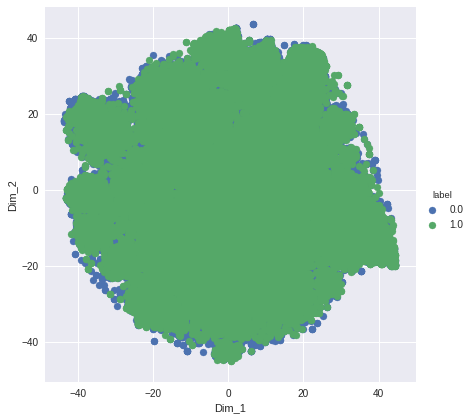

In [0]:
#print(tsne_data.shape)
#print(final_label_2000.shape)

#print(tsne_data.shape)
#print(tsne_data.T.shape)
#print(final_label_2000.shape)
tsne_data = np.vstack((tsne_data.T, final_label_2000)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df['label'].value_counts()
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TSNE BOW with  6000 Words

In [37]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_counts.todense())
print(tsne_data.shape)
print(final_label_6000.shape)

(6000, 2)
(6000,)


(6000, 3)


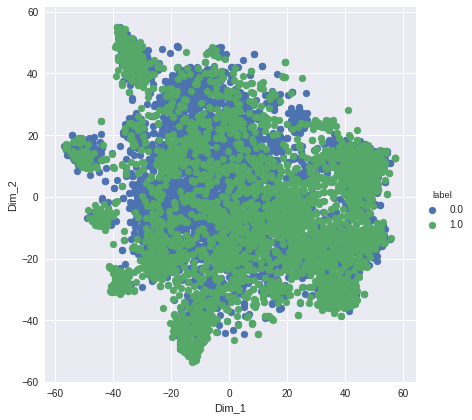

In [38]:
#print(tsne_data.shape)
#print(final_label_2000.shape)

#print(tsne_data.shape)
#print(tsne_data.T.shape)
#print(final_label_2000.shape)
tsne_data = np.vstack((tsne_data.T, final_label_6000)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df['label'].value_counts()
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Bagof Words on 2-Gram

In [31]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2),max_features=100 ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_6000.to_dense())
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 100)
the number of unique words including both unigrams and bigrams  100


# TSNE on BOW Bi-Gram

(6000, 3)
(6000,)
(100, 6000)
(6000,)
(6000, 3)


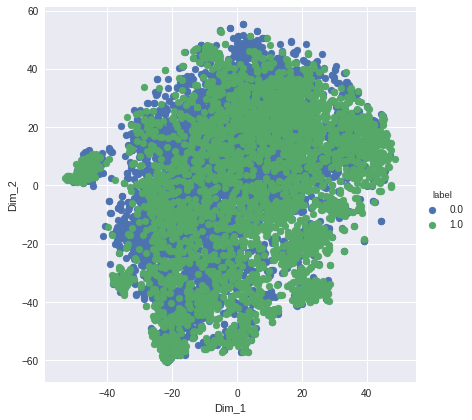

In [32]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
final_bigram_counts_tsne_data = model.fit_transform(final_bigram_counts.todense())
print(tsne_data.shape)
print(final_label_6000.shape)


print(final_bigram_counts.T.shape)
print(final_label_6000.shape)
tsne_data = np.vstack((final_bigram_counts_tsne_data.T, final_label_6000)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df['label'].value_counts()
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF on Bi-Gram

In [11]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_df=0.95, min_df=2,stop_words='english',max_features=10000)
final_tf_idf = tf_idf_vect.fit_transform(final_2000)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6000, 10000)
the number of unique words including both unigrams and bigrams  10000


In [12]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) []


In [0]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [15]:
from sklearn.manifold import TSNE


#model = TSNE(n_components=2, random_state=0)
#tsne_data = model.fit_transform(final_counts.todense())
#print(tsne_data.shape)
#print(final_label_2000.shape)

model = TSNE(n_components=2, random_state=0)
final_TFIDF_counts_tsne_data = model.fit_transform(final_tf_idf.todense())
print(final_TFIDF_counts_tsne_data.shape)
print(final_label_6000.shape)




(6000, 2)
(6000,)


(2, 6000)
(6000,)
(6000, 3)


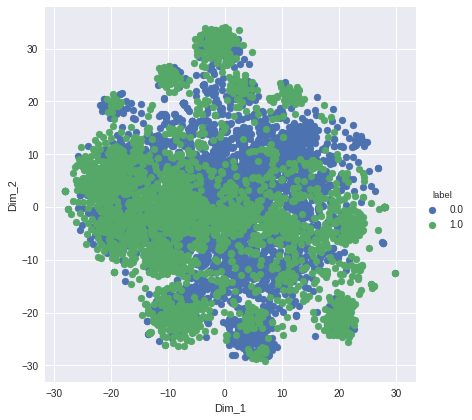

In [16]:
print(final_TFIDF_counts_tsne_data.T.shape)
print(final_label_2000.shape)
tsne_data = np.vstack((final_TFIDF_counts_tsne_data.T, final_label_2000)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df['label'].value_counts()
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Average Word2Vec

In [0]:
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_6000.values:
    list_of_sent.append(sent.split())

In [19]:
print(final_6000.values[0])
print("*****************************************************************")
print(list_of_sent[0])

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

w2v_model.wv.most_similar('tasti')
w2v_model.wv.most_similar('like')

this witti littl book make son laugh loud recit the car were drive along and alway can sing the refrain hes learn about whale india droop love all the new word this book introduc and the silli all this classic book will bet son will still abl recit from memori when colleg
*****************************************************************
['this', 'witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'the', 'car', 'were', 'drive', 'along', 'and', 'alway', 'can', 'sing', 'the', 'refrain', 'hes', 'learn', 'about', 'whale', 'india', 'droop', 'love', 'all', 'the', 'new', 'word', 'this', 'book', 'introduc', 'and', 'the', 'silli', 'all', 'this', 'classic', 'book', 'will', 'bet', 'son', 'will', 'still', 'abl', 'recit', 'from', 'memori', 'when', 'colleg']
number of words that occured minimum 5 times  4074
sample words  ['this', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'the', 'car', 'were', 'drive', 'along', 'and', 'alway', 'can', 'sing', 'hes', 'learn', 'about', 'india', 'lo

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tast', 0.8456425666809082),
 ('bitter', 0.8390761017799377),
 ('doesnt', 0.8359125852584839),
 ('smell', 0.8358784914016724),
 ('doe', 0.8152127861976624),
 ('feel', 0.8092530369758606),
 ('real', 0.8017215728759766),
 ('strong', 0.7998238801956177),
 ('seem', 0.7889776229858398),
 ('sweet', 0.7861379981040955)]

In [20]:
from  tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████| 6000/6000 [00:07<00:00, 763.66it/s]

6000
50


# plot on Average Word2Vec

In [21]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
final_AvgW2V_data = model.fit_transform(sent_vectors)
print(final_AvgW2V_data.shape)
print(final_label_6000.shape)

(6000, 2)
(6000,)


(2, 6000)
(6000,)
(6000, 3)


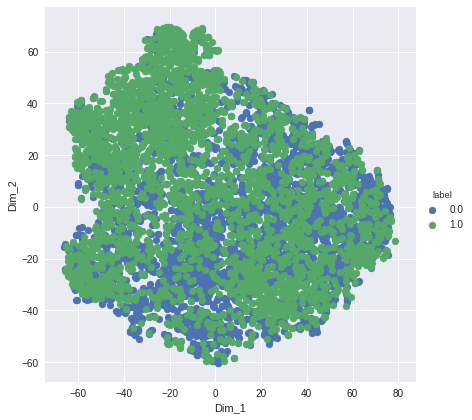

In [23]:
print(final_AvgW2V_data.T.shape)
print(final_label_2000.shape)
tsne_data = np.vstack((final_AvgW2V_data.T, final_label_6000)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df['label'].value_counts()
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF on AVG W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_6000.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [25]:
tf_idf_matrix.shape

(6000, 15806)

In [26]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [00:11<00:00, 525.92it/s]


In [28]:
len(tfidf_sent_vectors[0])

50

# TSNE on Avg W2V

In [29]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
final_AvgTFIDFW2V_data = model.fit_transform(tfidf_sent_vectors)
print(final_AvgTFIDFW2V_data.shape)
print(final_AvgTFIDFW2V_data.shape)

(6000, 2)
(6000, 2)


(2, 6000)
(6000,)
(6000, 3)


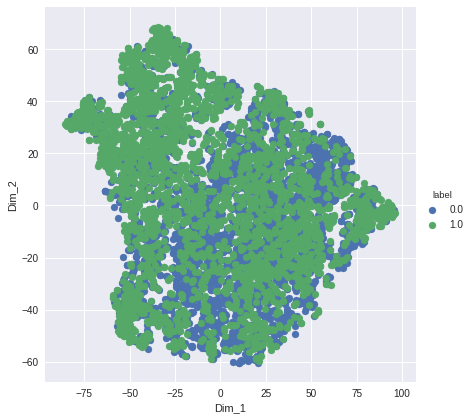

In [30]:
print(final_AvgTFIDFW2V_data.T.shape)
print(final_label_6000.shape)
tsne_data = np.vstack((final_AvgTFIDFW2V_data.T, final_label_6000)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df['label'].value_counts()
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()